In [1]:
!pip install torch_geometric
!pip install biopython
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 80.5 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import requests
import networkx as nx
from scipy.spatial.distance import euclidean
from Bio.PDB import PDBParser, PDBList
from torch_geometric.nn import GCNConv, GraphNorm, global_mean_pool

from google.colab import drive
drive.mount('/content/drive')

from torch.utils.data import Dataset




Mounted at /content/drive


In [4]:
class DeltaDDGDataset(Dataset):
    def __init__(self, all_results):
        self.all_results = all_results

    def __len__(self):
        return len(self.all_results)

    def __getitem__(self, idx):
        return self.all_results[idx]

    def save(self, path):
        data = {
            'all_results': self.all_results,
        }
        torch.save(data, path)

    @classmethod
    def load(cls, path):
        data = torch.load(path, weights_only=False)
        obj = cls.__new__(cls)
        obj.all_results = data['all_results']
        return obj

# Build Official Encoder and Predictor Classes for Fusion Model



In [5]:
#GNN Encoder:

class ProteinGNNEncoder(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim,    hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.norm1 = GraphNorm(hidden_dim)
        self.norm2 = GraphNorm(hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)
        self.norm4 = GraphNorm(hidden_dim)

        self.project = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        x0 = F.relu(self.norm1(self.conv1(x, edge_index)))

        x1 = F.relu(self.norm2(self.conv2(x0, edge_index))) + x0

        x2 = F.relu(self.norm3(self.conv3(x1, edge_index))) + x1

        x3 = F.relu(self.norm4(self.conv4(x2, edge_index))) + x2

        h = global_mean_pool(x3, batch)

        end_g_encode = self.project(h)
        return end_g_encode

In [6]:
#GNN Predictor:

class DeltaDDGPredictor(nn.Module):
    def __init__(self, encoder, embed_dim):
        super().__init__()
        self.encoder = encoder
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(embed_dim * 2, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, 1)
)

    def forward(self, data_wt, data_mut):
        h_wt = self.encoder(data_wt.x, data_wt.edge_index, data_wt.batch)
        h_mut = self.encoder(data_mut.x, data_mut.edge_index, data_mut.batch)
        h_diff = h_mut - h_wt
        return self.regressor(h_diff).squeeze()


In [7]:
#Fusion Predictor Class for both ESM and GNN

from transformers import AutoTokenizer, EsmModel

class DDGFusionPredictor(nn.Module):
    def __init__(self,
                 esm_model_name="facebook/esm2_t6_8M_UR50D",
                 embedding_dim=320,
                 conv_channels=128,
                 heads=4,
                 ffn_dim=256,
                 hidden_dim = 256,
                 in_dim = 20):
        super().__init__()

        # Device setup for trainable layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM model on CPU
        self.tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model = EsmModel.from_pretrained(esm_model_name).eval()
        for param in self.esm_model.parameters():
            param.requires_grad = False

        self.conv1 = GCNConv(in_dim,    hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.gnorm1 = GraphNorm(hidden_dim)
        self.gnorm2 = GraphNorm(hidden_dim)
        self.gnorm3 = GraphNorm(hidden_dim)
        self.gnorm4 = GraphNorm(hidden_dim)
        self.embedding_dim = self.esm_model.config.hidden_size
        self.project = nn.Linear(hidden_dim, self.embedding_dim)

        # Convolutional encoder
        self.conv1d = nn.Conv1d(2*self.embedding_dim, conv_channels, kernel_size=3, padding=1)

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=conv_channels, num_heads=heads, batch_first=True)

        self.norm1 = nn.LayerNorm(conv_channels)
        self.norm2 = nn.LayerNorm(conv_channels)

        # Position-wise feedforward
        self.ffn = nn.Sequential(
            nn.Linear(conv_channels, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, conv_channels)
        )
        self.dropout = nn.Dropout(0.3)
        # Pooling layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        #Regression head
        self.regressor = nn.Sequential(
          nn.Linear(conv_channels * 2, 256),
          nn.ReLU(),
          nn.Dropout(0.3),
          nn.Linear(256, 64),
          nn.ReLU(),
          nn.Linear(64, 1)
       )


    def forward(self, wt_seq, mt_seq, data_wt, data_mut):
        # Tokenize and compute embeddings on CPU without gradients
        with torch.no_grad():
            wt_tokens = self.tokenizer(wt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)
            mt_tokens = self.tokenizer(mt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)

            wt_tokens = {k: v.to(self.device) for k, v in wt_tokens.items()}
            mt_tokens = {k: v.to(self.device) for k, v in mt_tokens.items()}

            wt_embed = self.esm_model(**wt_tokens).last_hidden_state[:, 1:-1, :]  # remove [CLS] and [SEP]
            mt_embed = self.esm_model(**mt_tokens).last_hidden_state[:, 1:-1, :]

            d = (wt_embed - mt_embed) # Move difference to GPU

        # Encde
        x0_wt = F.relu(self.gnorm1(self.conv1(data_wt.x, data_wt.edge_index)))
        x0_mut = F.relu(self.gnorm1(self.conv1(data_mut.x, data_mut.edge_index)))

        x1_wt = F.relu(self.gnorm2(self.conv2(x0_wt, data_wt.edge_index))) + x0_wt
        x1_mut = F.relu(self.gnorm2(self.conv2(x0_mut, data_mut.edge_index))) + x0_mut

        # x2 = F.relu(self.norm3(self.conv3(x1, data_wt.edge_index))) + x1
        x2_wt = F.relu(self.gnorm3(self.conv3(x1_wt, data_wt.edge_index))) + x1_wt
        x2_mut = F.relu(self.gnorm3(self.conv3(x1_mut, data_mut.edge_index))) + x1_mut

        x3_wt = F.relu(self.gnorm4(self.conv4(x2_wt, data_wt.edge_index))) + x2_wt
        x3_mut = F.relu(self.gnorm4(self.conv4(x2_mut, data_mut.edge_index))) + x2_mut

        h_wt = global_mean_pool(x3_wt, data_wt.batch)
        h_mut = global_mean_pool(x3_mut, data_mut.batch)

        end_g_encode_wt = self.project(h_wt)
        end_g_encode_mut = self.project(h_mut)

        d_g_encode = end_g_encode_wt - end_g_encode_mut


        B, L, D_esm = d.shape
        d_g_encode_exp = d_g_encode.unsqueeze(1).expand(-1, L, D_esm)

        conc_emb = torch.cat([d, d_g_encode_exp], dim=2)  # Shape: [B, L, 2*D_esm]

        c = self.conv1d(conc_emb.transpose(1, 2)).transpose(1, 2)  # Expected shape: (B, L, C)

        # Multi-head attention + residual
        m, _ = self.attention(c, c, c)

        z = self.norm1(c + m)

        # Position-wise feedforward + residual
        f = self.norm2(z + self.dropout(self.ffn(z)))

        # Global pooling
        f_t = f.transpose(1, 2)  # (B, C, L)
        gp = self.global_avg_pool(f_t).squeeze(-1)  # (B, C)
        gm = self.global_max_pool(f_t).squeeze(-1)  # (B, C)
        conc = torch.cat([gp, gm], dim=1)  # (B, 2C)
        conc = self.dropout(conc)

        # Final regression output
        ddg_pred = self.regressor(conc).view(-1)
        return ddg_pred

In [8]:
master_model = DDGFusionPredictor()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load Saved Data and Train Model

In [10]:
# LOAD FROM AGGREGATED DATA

# train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_train_set.pkl")
# val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/official_val_set.pkl")

# #convert to dataloader object for training

# train_loader_official = DataLoader(train_dataset_loaded, batch_size=4, shuffle=True)
# val_loader_official = DataLoader(val_dataset_loaded, batch_size=4)


train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/train_dataset_yuh.pkl")
val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/val_dataset_yuh.pkl")#, weights_only=False)
test_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/test_dataset_yuh.pkl")#, weights_only=False)

#convert to dataloader object for training

train_loader_official = DataLoader(train_dataset_loaded, batch_size=16, shuffle=True)
val_loader_official = DataLoader(val_dataset_loaded, batch_size=16)
test_loader_official = DataLoader(test_dataset_loaded, batch_size=16)


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [11]:
##### Train Block

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import copy


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DDGFusionPredictor()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.HuberLoss(delta=1.0)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_losses = []
val_losses = []
val_mse_scores = []
val_auc_scores = []
best_model_path = "/content/drive/MyDrive/BMI_707_Project/Official Model Performance /Fusion Model/fusion_best_model.pt"


best_val_loss = float("inf")

def train(model, optimizer, criterion, dataloader, device):
    model.train()
    total_loss = 0
    for data_wt, data_mut, ddg, metadata in tqdm(dataloader):
        wt_seqs = metadata['sequence']
        mt_seqs = metadata['mt_sequence']

        optimizer.zero_grad()
        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = model(wt_seqs, mt_seqs, data_wt, data_mut)
        loss = criterion(pred, ddg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * ddg.size(0)
    return total_loss / len(dataloader.dataset)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data_wt, data_mut, ddg, metadata in tqdm(dataloader):
            wt_seqs = metadata['sequence']
            mt_seqs = metadata['mt_sequence']

            data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
            pred = model(wt_seqs, mt_seqs, data_wt, data_mut)
            loss = criterion(pred, ddg)
            total_loss += loss.item() * ddg.size(0)
            all_preds.extend(pred.view(-1).cpu().numpy())
            all_targets.extend(ddg.view(-1).cpu().numpy())


    mse = criterion(torch.tensor(all_preds), torch.tensor(all_targets)).item()

    return total_loss / len(dataloader.dataset), mse

import math

for epoch in range(10):
    model.train()
    train_loss = train(model, optimizer, criterion, train_loader_official, device)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")

    val_loss, val_mse = evaluate(model, val_loader_official, criterion, device)
    val_losses.append(val_loss)
    val_mse_scores.append(val_mse)

    val_rmse = math.sqrt(val_mse)

    print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}")

    # Save best model
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = copy.deepcopy(model)
      torch.save(best_model.state_dict(), best_model_path)
      #torch.save(best_model.state_dict(), best_model_path)
      print(f"✅ Saved new best model at epoch {epoch+1} (Val Loss: {val_loss:.4f})")




Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 189/189 [00:26<00:00,  7.19it/s]


Epoch 0, Train Loss: 2.9353


100%|██████████| 24/24 [00:02<00:00,  9.16it/s]


Epoch 0, Val Loss: 2.6667, MSE: 2.6667, RMSE: 1.6330
✅ Saved new best model at epoch 1 (Val Loss: 2.6667)


100%|██████████| 189/189 [00:24<00:00,  7.72it/s]


Epoch 1, Train Loss: 2.3391


100%|██████████| 24/24 [00:02<00:00,  9.25it/s]


Epoch 1, Val Loss: 2.3031, MSE: 2.3031, RMSE: 1.5176
✅ Saved new best model at epoch 2 (Val Loss: 2.3031)


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 2, Train Loss: 2.0344


100%|██████████| 24/24 [00:02<00:00,  9.23it/s]


Epoch 2, Val Loss: 2.1341, MSE: 2.1341, RMSE: 1.4609
✅ Saved new best model at epoch 3 (Val Loss: 2.1341)


100%|██████████| 189/189 [00:24<00:00,  7.64it/s]


Epoch 3, Train Loss: 1.7433


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


Epoch 3, Val Loss: 2.0575, MSE: 2.0575, RMSE: 1.4344
✅ Saved new best model at epoch 4 (Val Loss: 2.0575)


100%|██████████| 189/189 [00:24<00:00,  7.73it/s]


Epoch 4, Train Loss: 1.5592


100%|██████████| 24/24 [00:02<00:00,  9.21it/s]


Epoch 4, Val Loss: 2.0456, MSE: 2.0456, RMSE: 1.4303
✅ Saved new best model at epoch 5 (Val Loss: 2.0456)


100%|██████████| 189/189 [00:24<00:00,  7.67it/s]


Epoch 5, Train Loss: 1.3910


100%|██████████| 24/24 [00:02<00:00,  9.27it/s]


Epoch 5, Val Loss: 1.9205, MSE: 1.9205, RMSE: 1.3858
✅ Saved new best model at epoch 6 (Val Loss: 1.9205)


100%|██████████| 189/189 [00:24<00:00,  7.70it/s]


Epoch 6, Train Loss: 1.2749


100%|██████████| 24/24 [00:02<00:00,  9.27it/s]


Epoch 6, Val Loss: 1.9125, MSE: 1.9125, RMSE: 1.3829
✅ Saved new best model at epoch 7 (Val Loss: 1.9125)


100%|██████████| 189/189 [00:24<00:00,  7.66it/s]


Epoch 7, Train Loss: 1.1506


100%|██████████| 24/24 [00:02<00:00,  9.23it/s]


Epoch 7, Val Loss: 1.8259, MSE: 1.8259, RMSE: 1.3512
✅ Saved new best model at epoch 8 (Val Loss: 1.8259)


100%|██████████| 189/189 [00:24<00:00,  7.72it/s]


Epoch 8, Train Loss: 1.0527


100%|██████████| 24/24 [00:02<00:00,  9.20it/s]


Epoch 8, Val Loss: 1.7913, MSE: 1.7913, RMSE: 1.3384
✅ Saved new best model at epoch 9 (Val Loss: 1.7913)


100%|██████████| 189/189 [00:24<00:00,  7.75it/s]


Epoch 9, Train Loss: 0.9540


100%|██████████| 24/24 [00:02<00:00,  9.33it/s]

Epoch 9, Val Loss: 1.9347, MSE: 1.9347, RMSE: 1.3909


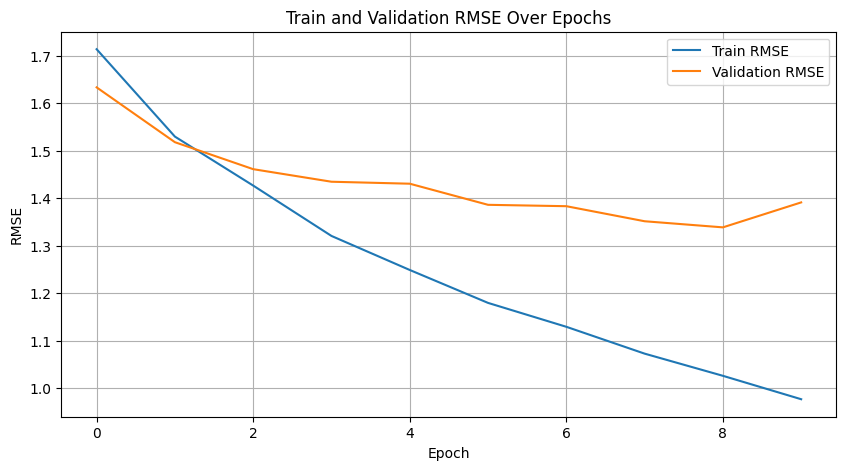

In [12]:
##### Plot RMSE for Train and Validation Sets

import numpy as np

train_rmse_scores = [np.sqrt(loss) for loss in train_losses]
val_rmse_scores = [np.sqrt(mse) for mse in val_mse_scores]

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_scores, label='Train RMSE')
plt.plot(val_rmse_scores, label='Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
##### Save Performance Data (to plot performances of all 3 models together)

# assemble into a DataFrame
df_fusion__model_performance_10_epochs_MSE = pd.DataFrame({
    'epoch': np.arange(1, len(train_rmse_scores) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_rmse': train_rmse_scores,
    'val_rmse': val_rmse_scores,
    'val_mse': val_mse_scores,
})

# save as CSV
df_fusion__model_performance_10_epochs_MSE.to_csv('Fusion_model_10_epochs_MSE', index=False)

Test: 100%|██████████| 24/24 [00:02<00:00,  8.45it/s]


📊 Test MSE:  1.9730
📊 Test RMSE: 1.4046
📊 Test MAE:  0.9909
📊 Test R²:   0.4223


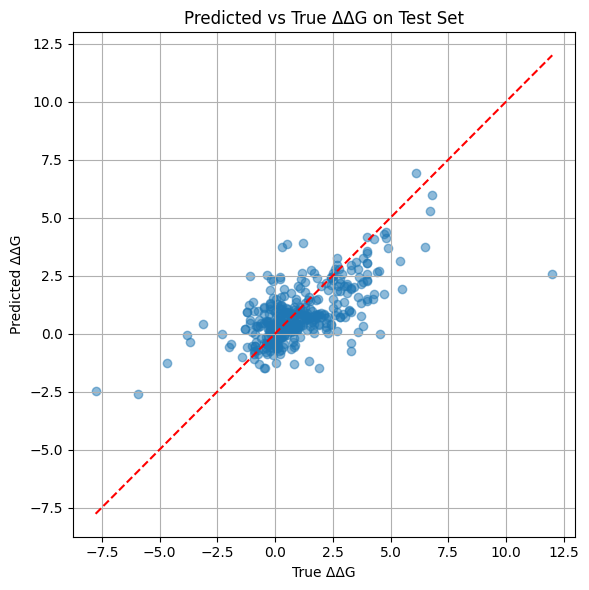

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

best_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for data_wt, data_mut, ddg, metadata in tqdm(test_loader_official, desc="Test"):
        wt_seqs = metadata['sequence']
        mt_seqs = metadata['mt_sequence']

        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = best_model(wt_seqs, mt_seqs, data_wt, data_mut)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(ddg.view(-1).cpu().numpy())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mse = mean_squared_error(all_targets, all_preds)
rmse = math.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"📊 Test MSE:  {mse:.4f}")
print(f"📊 Test RMSE: {rmse:.4f}")
print(f"📊 Test MAE:  {mae:.4f}")
print(f"📊 Test R²:   {r2:.4f}")

# Plot: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel('True ΔΔG')
plt.ylabel('Predicted ΔΔG')
plt.title('Predicted vs True ΔΔG on Test Set')
plt.grid(True)
plt.tight_layout()
plt.show()


100%|██████████| 24/24 [00:02<00:00,  9.13it/s]


✅ Pearson r = 0.670 (p=2.7e-50)
✅ Spearman ρ = 0.634
✅ R² = 0.410


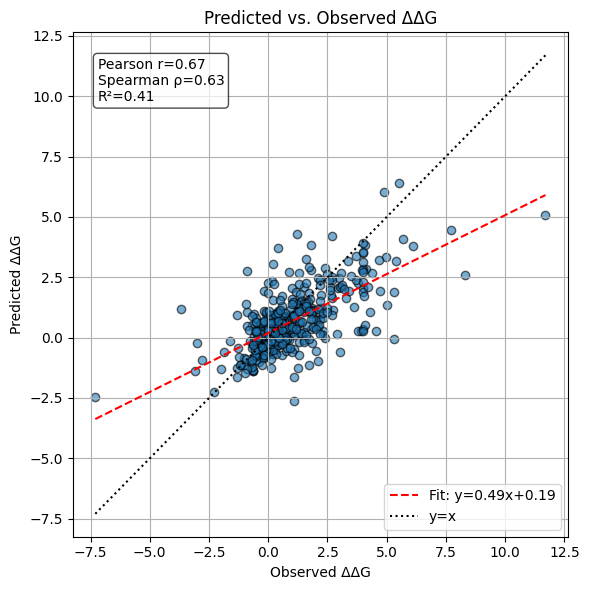

In [16]:
##### Correlations Plot

import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

model.eval()
preds, targets = [], []

with torch.no_grad():
    for data_wt, data_mut, ddg, metadata in tqdm(val_loader_official):
        wt_seqs = metadata['sequence']
        positions = metadata['position']
        mt_seqs = [''] * len(wt_seqs)

        for i in range(len(wt_seqs)):
            pos = min(positions[i] - 1, len(wt_seqs[i]) - 1)
            mt_seq = list(wt_seqs[i])
            mt_seq[pos] = metadata['mutation'][i]
            mt_seqs[i] = ''.join(mt_seq)

        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = model(wt_seqs, mt_seqs, data_wt, data_mut)

        preds.extend(pred.view(-1).cpu().numpy())
        targets.extend(ddg.view(-1).cpu().numpy())

# Convert to numpy arrays
preds = np.array(preds)
targets = np.array(targets)

# Metrics
pearson_r, pearson_p = pearsonr(targets, preds)
spearman_rho, _ = spearmanr(targets, preds)
r2 = r2_score(targets, preds)

print(f"✅ Pearson r = {pearson_r:.3f} (p={pearson_p:.1e})")
print(f"✅ Spearman ρ = {spearman_rho:.3f}")
print(f"✅ R² = {r2:.3f}")

# Plot predicted vs. true
m, b = np.polyfit(targets, preds, 1)
x_line = np.linspace(targets.min(), targets.max(), 100)

plt.figure(figsize=(6, 6))
plt.scatter(targets, preds, alpha=0.6, edgecolor='k')
plt.plot(x_line, m * x_line + b, 'r--', label=f'Fit: y={m:.2f}x+{b:.2f}')
plt.plot(x_line, x_line, 'k:', label='y=x')

plt.xlabel("Observed ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("Predicted vs. Observed ΔΔG")
plt.legend(loc="best")
plt.text(0.05, 0.95,
         f"Pearson r={pearson_r:.2f}\nSpearman ρ={spearman_rho:.2f}\nR²={r2:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.grid(True)
plt.tight_layout()
plt.show()


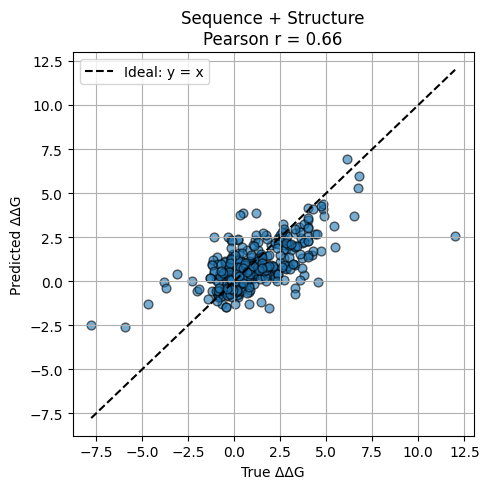

In [18]:
##### Updated Correlations Plot

import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Evaluate best model on validation (or test) set
preds, targets = [], []
best_model.eval()
with torch.no_grad():
    for data_wt, data_mut, ddg, metadata in test_loader_official:
        wt_seqs = metadata['sequence']
        mt_seqs = metadata['mt_sequence']

        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = best_model(wt_seqs, mt_seqs, data_wt, data_mut)

        preds.extend(pred.view(-1).cpu().numpy())
        targets.extend(ddg.view(-1).cpu().numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)

# Pearson only
pearson_r, _ = pearsonr(targets, preds)

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(targets, preds, alpha=0.6, color='#1f77b4', edgecolor='k', s=40)  # blue
ax.plot([min(targets), max(targets)], [min(targets), max(targets)], 'k--', label='Ideal: y = x')
ax.set_xlabel('True ΔΔG')
ax.set_ylabel('Predicted ΔΔG')
ax.set_title('Sequence + Structure\nPearson r = {:.2f}'.format(pearson_r))
ax.legend()
ax.grid(True)
ax.set_ylim(min(targets)-1, max(targets)+1)
ax.set_xlim(min(targets)-1, max(targets)+1)
plt.tight_layout()
plt.show()


# Error Analysis


Re-checking metadata: 100%|██████████| 24/24 [00:02<00:00,  8.50it/s]


❗ 52 samples with absolute error > 2.0


,True ΔΔG,Predicted ΔΔG,Absolute Error,Protein Length,Mutation Position
331,12.00,2.584815,9.415185,150,tensor(123)
338,-7.77,-2.489516,5.280484,746,tensor(268)
32,4.54,-0.027319,4.567319,393,tensor(270)
324,3.30,-0.741518,4.041518,393,tensor(282)
141,-3.80,-0.041880,3.758120,418,tensor(207)
165,3.29,-0.391004,3.681004,393,tensor(255)
179,5.50,1.915322,3.584678,231,tensor(191)
315,-1.08,2.489971,3.569971,92,tensor(12)
283,3.60,0.065677,3.534323,87,tensor(34)
201,-3.10,0.427701,3.527701,109,tensor(36)


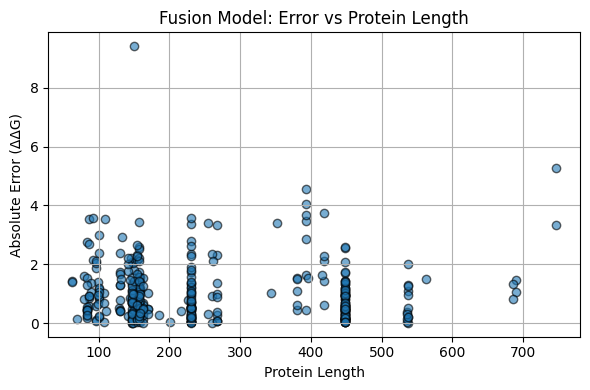

from matplotlib import pyplot as plt
_df_0['True ΔΔG'].plot(kind='hist', bins=20, title='True ΔΔG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Predicted ΔΔG'].plot(kind='hist', bins=20, title='Predicted ΔΔG')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Absolute Error'].plot(kind='hist', bins=20, title='Absolute Error')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Protein Length'].plot(kind='hist', bins=20, title='Protein Length')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='True ΔΔG', y='Predicted ΔΔG', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Predicted ΔΔG', y='Absolute Error', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Absolute Error', y='Protein Length', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['True ΔΔG'].plot(kind='line', figsize=(8, 4), title='True ΔΔG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Predicted ΔΔG'].plot(kind='line', figsize=(8, 4), title='Predicted ΔΔG')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['Absolute Error'].plot(kind='line', figsize=(8, 4), title='Absolute Error')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Protein Length'].plot(kind='line', figsize=(8, 4), title='Protein Length')
plt.gca().spines[['top', 'right']].set_visible(False)

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Recompute predictions and errors
errors = np.abs(all_preds - all_targets)

# Step 2: Extract relevant metadata
protein_lengths = []
mutation_positions = []
true_ddg = []
pred_ddg = []

with torch.no_grad():
    for data_wt, data_mut, ddg, metadata in tqdm(test_loader_official, desc="Re-checking metadata"):
        wt_seqs = metadata['sequence']
        mt_seqs = metadata['mt_sequence']
        positions = metadata.get('position', [None]*len(wt_seqs))

        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        preds = best_model(wt_seqs, mt_seqs, data_wt, data_mut).view(-1).cpu().numpy()

        for i in range(len(wt_seqs)):
            protein_lengths.append(len(wt_seqs[i]))
            mutation_positions.append(positions[i] if positions[i] is not None else -1)
            true_ddg.append(ddg[i].item())
            pred_ddg.append(preds[i])

# Step 3: Build DataFrame
df = pd.DataFrame({
    "True ΔΔG": true_ddg,
    "Predicted ΔΔG": pred_ddg,
    "Absolute Error": np.abs(np.array(true_ddg) - np.array(pred_ddg)),
    "Protein Length": protein_lengths,
    "Mutation Position": mutation_positions
})

# Step 4: Filter large error samples
threshold = 2.0  # You can adjust this
df_bad = df[df["Absolute Error"] > threshold]

# Step 5: Summary + Visual Inspection
print(f"❗ {len(df_bad)} samples with absolute error > {threshold}")
display(df_bad.sort_values(by="Absolute Error", ascending=False).head(10))  # top offenders

# Step 6: Plot error vs protein length
plt.figure(figsize=(6, 4))
plt.scatter(df["Protein Length"], df["Absolute Error"], alpha=0.6, edgecolor='k')
plt.xlabel("Protein Length")
plt.ylabel("Absolute Error (ΔΔG)")
plt.title("Fusion Model: Error vs Protein Length")
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Mann-Whitney U test: p = 0.2279
📈 Spearman correlation between length and error: r = -0.103, p = 0.0455


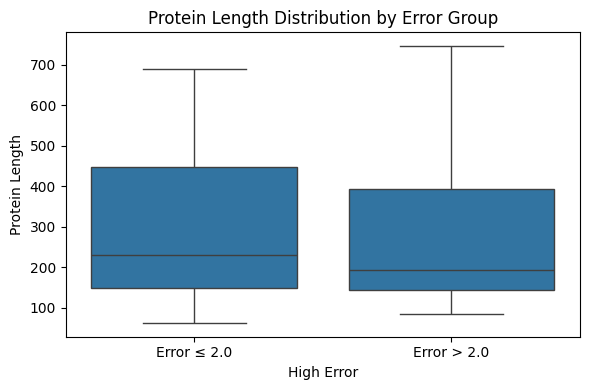

In [20]:
from scipy.stats import mannwhitneyu, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Add a "High Error" label to dataframe
df["High Error"] = df["Absolute Error"] > 2.0

# 1. Mann-Whitney U Test (nonparametric) between lengths of high- and low-error groups
high_error_lengths = df[df["High Error"]]["Protein Length"]
low_error_lengths = df[~df["High Error"]]["Protein Length"]

stat, p_val = mannwhitneyu(high_error_lengths, low_error_lengths, alternative='two-sided')
print(f"📊 Mann-Whitney U test: p = {p_val:.4f}")

# 2. Spearman correlation between length and error
corr, corr_p = spearmanr(df["Protein Length"], df["Absolute Error"])
print(f"📈 Spearman correlation between length and error: r = {corr:.3f}, p = {corr_p:.4f}")

# 3. Plot distributions
plt.figure(figsize=(6,4))
sns.boxplot(x="High Error", y="Protein Length", data=df)
plt.title("Protein Length Distribution by Error Group")
plt.xticks([0,1], ["Error ≤ 2.0", "Error > 2.0"])
plt.tight_layout()
plt.show()


# Validating the Loaded PKL's and Wrapper for Old DeltaDDGDataset Class

In [ ]:
train_dataset.meta[0]

{'experiment_id': 'VB05069',
 'protein_name': 'Thermonuclease',
 'uniprot_id': 'P00644',
 'pdb_id': '1STN|1EY0',
 'chain': 'A',
 'position': 164,
 'wild_type': 'T',
 'mutation': 'S',
 'ddG': 0.6,
 'sequence': 'MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSCLVLTLVVVSSLSSSANASQTDNGVNRSGSEDPTVYSATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEKLNIWSEDNADSGQ',
 'is_in_catalytic_pocket': True,
 'is_essential': False}

In [ ]:
temp = train_dataset.meta[0]
temp.pop("sequence_mt")

'hello'

In [ ]:
train_dataset.meta[0]

{'experiment_id': 'VB05069',
 'protein_name': 'Thermonuclease',
 'uniprot_id': 'P00644',
 'pdb_id': '1STN|1EY0',
 'chain': 'A',
 'position': 164,
 'wild_type': 'T',
 'mutation': 'S',
 'ddG': 0.6,
 'sequence': 'MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSCLVLTLVVVSSLSSSANASQTDNGVNRSGSEDPTVYSATSTKKLHKEPATLIKAIDGDTVKLMYKGQPMTFRLLLVDTPETKHPKKGVEKYGPEASAFTKKMVENAKKIEVEFDKGQRTDKYGRGLAYIYADGKMVNEALVRQGLAKVAYVYKPNNTHEQHLRKSEAQAKKEKLNIWSEDNADSGQ',
 'is_in_catalytic_pocket': True,
 'is_essential': False}

In [ ]:
"hel# Update sequence_mutant column
for index, row in df.iterrows():
  s = list(row["sequence_mutant"])
  s[row["position"]-1] = row["mutation"]
  s = "".join(s)
  df.at[index,"sequence_mutant"] = s

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [ ]:
next(iter(train_loader))

[DataBatch(x=[632, 23], edge_index=[2, 5548], edge_attr=[5548, 1], y=[4], batch=[632], ptr=[5]),
 DataBatch(x=[488, 23], edge_index=[2, 4610], edge_attr=[4610, 1], y=[4], batch=[488], ptr=[5]),
 tensor([-0.5000,  2.0000,  2.3000,  0.4000])]

In [ ]:
train_dataset.meta

In [ ]:
##### wrapper to include metadata and saving

import pickle
import torch

class DatasetWithMetadata(torch.utils.data.Dataset):
    def __init__(self, base_dataset, metadata):
        self.base_dataset = base_dataset
        self.metadata = metadata

    def __len__(self):
        return len(self.metadata) # return self.base_dataset.__len__()

    def __getitem__(self, idx):
        # data_wt, data_mut, ddg = self.base_dataset[idx]
        data_wt, data_mut, ddg = self.base_dataset.__getitem__(idx)
        meta = self.metadata[idx]
        return data_wt, data_mut, ddg, meta

    def save(self, filepath):
        """Save the dataset wrapper and all needed components."""
        to_save = {
            'pairs': self.base_dataset.pairs,
            'metadata': self.metadata
        }
        with open(filepath, 'wb') as f:
            pickle.dump(to_save, f)
        print(f"✅ Dataset saved to {filepath}")

    @classmethod
    def load(cls, filepath):
            """Load the dataset and return a DatasetWithMetadata object."""
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)

            class BasePairsDataset(torch.utils.data.Dataset):
                def __init__(self, pairs):
                    self.pairs = pairs

                def __len__(self):
                    return len(self.pairs)

                def __getitem__(self, idx):
                    return self.pairs[idx]

            base_dataset = BasePairsDataset(obj['pairs'])
            return cls(base_dataset=base_dataset, metadata=obj['metadata'])



In [ ]:
train_dataset_wrapped = DatasetWithMetadata(train_dataset, train_dataset.meta)
val_dataset_wrapped = DatasetWithMetadata(val_dataset, val_dataset.meta)


In [ ]:
train_loader = DataLoader(train_dataset_wrapped, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset_wrapped, batch_size=4)

# next(iter(train_loader))

NameError: name 'train_dataset_wrapped' is not defined

In [ ]:
next(iter(train_loader))

[DataBatch(x=[1013, 23], edge_index=[2, 8688], edge_attr=[8688, 1], y=[4], batch=[1013], ptr=[5]),
 DataBatch(x=[741, 23], edge_index=[2, 7306], edge_attr=[7306, 1], y=[4], batch=[741], ptr=[5]),
 tensor([-0.4800,  3.0000,  3.5000,  2.6000]),
 {'experiment_id': ['PT021091', 'LL002149', 'VB01894', 'VB05344'],
  'protein_name': ['Cold shock protein CspB',
   'Cellular tumor antigen p53',
   'Ribonuclease',
   'Maltose/maltodextrin-binding periplasmic protein'],
  'uniprot_id': ['P32081', 'P04637', 'P00648', 'P0AEX9'],
  'pdb_id': ['1CSP',
   '1TUP|1TUP|1TUP|1TUP|1TUP|1SAK|1SAK|1SAK|1SAK|2OCJ',
   '1BNI|1A2P',
   '3MBP|1SVX|1SVX'],
  'chain': ['A', 'A', 'A', 'A'],
  'position': tensor([ 55, 282,  60, 115]),
  'wild_type': ['N', 'R', 'Y', 'L'],
  'mutation': ['D', 'W', 'A', 'A'],
  'ddG': tensor([-0.4800,  3.0000,  3.5000,  2.6000]),
  'sequence': ['MLEGKVKWFNSEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQAVSFEIVEGNRGPQAANVTKEA',
   'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPE

In [ ]:
train_dataset_wrapped.save("train_dataset_with_metadata.pkl")
val_dataset_wrapped.save("val_dataset_with_metadata.pkl")


✅ Dataset saved to train_dataset_with_metadata.pkl
✅ Dataset saved to val_dataset_with_metadata.pkl


In [ ]:
train_dataset_wrapped_ahhhh = DatasetWithMetadata.load("train_dataset_with_metadata.pkl")
val_dataset_wrapped_ahhhh = DatasetWithMetadata.load("val_dataset_with_metadata.pkl")


NameError: name 'DatasetWithMetadata' is not defined

In [ ]:
!ls -lh


total 8.0K
drwx------ 6 root root 4.0K May  4 16:29 drive
drwxr-xr-x 1 root root 4.0K Apr 30 13:37 sample_data


In [ ]:
train_dataset_wrapped_loader = DataLoader(train_dataset_wrapped_ahhhh, batch_size=4, shuffle=True)
val_dataset_wrapped_loader = DataLoader(val_dataset_wrapped_ahhhh, batch_size=4)

In [ ]:
next(iter(train_dataset_wrapped_loader))

[DataBatch(x=[2725, 23], edge_index=[2, 26222], edge_attr=[26222, 1], y=[4], batch=[2725], ptr=[5]),
 DataBatch(x=[599, 23], edge_index=[2, 5748], edge_attr=[5748, 1], y=[4], batch=[599], ptr=[5]),
 tensor([-0.6000, -6.2000,  2.8000,  2.4000]),
 {'experiment_id': ['VB00708', 'VB03666', 'PT019624', 'VB02977'],
  'protein_name': ['Ribonuclease HI',
   'Tryptophan synthase alpha chain',
   '30S ribosomal protein S6',
   'Tenascin'],
  'uniprot_id': ['P0A7Y4', 'P0A877', 'P23370', 'P24821'],
  'pdb_id': ['2RN2', '1WQ5', '1RIS|1RIS|1RIS|1RIS', '1TEN'],
  'chain': ['A', 'A', 'A', 'A'],
  'position': tensor([ 23,  49,  26, 849]),
  'wild_type': ['G', 'E', 'I', 'I'],
  'mutation': ['A', 'L', 'A', 'A'],
  'ddG': tensor([-0.6000, -6.2000,  2.8000,  2.4000]),
  'sequence': ['MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNRMELMAAIVALEALKEHCEVILSTDSQYVRQGITQWIHNWKKRGWKTADKKPVKNVDLWQRLDAALGQHQIKWEWVKGHAGHPENERCDELARAAAMNPTLEDTGYQVEV',
   'MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGADALELGIPFSDPLADGPTI

In [ ]:
train_dataset.__getitem__(0)

(Data(x=[231, 23], edge_index=[2, 2004], edge_attr=[2004, 1], y=[1], batch=[231]),
 Data(x=[136, 23], edge_index=[2, 1334], edge_attr=[1334, 1], y=[1], batch=[136]),
 tensor(0.6000))